## Example calculation of finite difference operators on A-grid using xgcm
* 'Finite volume' versions, as in Ryan's xgcm example, require area and length
metrics on each of the discrete trapezoids and then, for example, 
the symbolic recipe for the divergence would be:

    Div(u,v) = [ (uh \* dyh).diff('X') + (vh \* dxh).diff('Y') ] / Area 

where (u,v,dx,dy) are at the trapezoid center and

    * uh = u.interp('X')
    * vh = v.interp('Y')
    * dyh = dy.interp('X')
    * dxh = dx.interp('Y')
    * Area = dx*dy (area of trapezoid)
    
Note that for an evenly spaced (lon,lat) grid, dy(meters) is constant but dx(meters) depends on cos(lat)

* Here we assume constant dx and dy and use the analytic formula to put the cos(lat) factor where needed


In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)
import xgcm
from glob import glob

### First we will import a sample vector field (u10,v10)
Note, this will only work on our machines which see the kage drives

In [2]:
files = '/net/kage/d5/datasets/ERAInterim/monthly/Surface/*10.nc'
ds1 = xr.open_mfdataset(glob(files),decode_times=False)
ds = ds1.mean('T')
ds

<xarray.Dataset>
Dimensions:  (X: 360, Y: 181)
Coordinates:
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * Y        (Y) float32 90.0 89.0 88.0 87.0 86.0 85.0 84.0 83.0 82.0 81.0 ...
Data variables:
    si10     (Y, X) float32 dask.array<shape=(181, 360), chunksize=(181, 360)>
    u10      (Y, X) float32 dask.array<shape=(181, 360), chunksize=(181, 360)>
    v10      (Y, X) float32 dask.array<shape=(181, 360), chunksize=(181, 360)>

### The reanalysis data is on an 'A-grid'  (all data on the same grid)

### We need to define the 'half point' or 'right' grids
N.B. The Y grid is going from North to South

In [3]:
delx = ds.X[1]-ds.X[0]; dely = ds.Y[1]-ds.Y[0]
xh = ds.X + delx/2.0; ds['Xh'] = ('Xh',xh)
yh = ds.Y + dely/2.0; ds['Yh'] = ('Yh',yh)
print('X grid:',ds.X.data[0:10],'\nXh grid:',ds.Xh.data[0:10])
print('Y grid:',ds.Y.data[0:10],'\nYh grid:',ds.Yh.data[0:10])

X grid: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.] 
Xh grid: [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5]
Y grid: [ 90.  89.  88.  87.  86.  85.  84.  83.  82.  81.] 
Yh grid: [ 89.5  88.5  87.5  86.5  85.5  84.5  83.5  82.5  81.5  80.5]


### Next we create our xgcm Grid:
Yes, I know it is not periodic in Y, but it is easier (don't need to give boundary=...) and we just won't look at the derivatives near the poles

In [4]:
grid = xgcm.Grid(ds, coords={'X': {'center': 'Xh', 'right': 'X'},
                             'Y': {'center': 'Yh', 'right': 'Y'}}, periodic=['X','Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   Xh (360) --> right
  * right    X (360) --> center
Y Axis (periodic):
  * center   Yh (181) --> right
  * right    Y (181) --> center

### and our metric terms:

In [6]:
coslat = np.cos(np.deg2rad(ds.Y))
coslath = np.cos(np.deg2rad(ds.Yh))
meterPdegree = 111000.0

dxm = delx*meterPdegree
dym = dely*meterPdegree

### Now that we have our grids and metrics defined, the hard part is over. 

### Let's use xgcm to calculate our standard differential operators: 
* divergence
* gradient
* curl 

### Divergence



The horizontal divergence of $\vec u = (u,v)$ in spherical coordinates is

$$ \nabla \cdot \vec u =   \frac{1}{\cos y} \left( \frac{\partial u}{\partial x} + \
                                         \frac{\partial (v \cos y )}{\partial y} \right)$$



In [7]:
# calculate the divergence of the 10m winds, (u10,v10)
# Method I
dudx = grid.diff(ds.u10,axis='X')/dxm  
dvdy = grid.diff(coslat*ds.v10,axis='Y')/dym
divergence = (grid.interp(dudx,axis='X')+ grid.interp(dvdy,axis='Y'))/coslat
ds['divergence1'] = divergence

In [8]:
# same calculation, 
# Method II (preferred)
uh = grid.interp(ds.u10,axis='X')
vh = grid.interp(ds.v10,axis='Y')
dudx = grid.diff(uh,axis='X')/dxm  
dvdy = grid.diff(coslath*vh,axis='Y')/dym
divergence = (dudx + dvdy)/coslat
ds['divergence'] = divergence

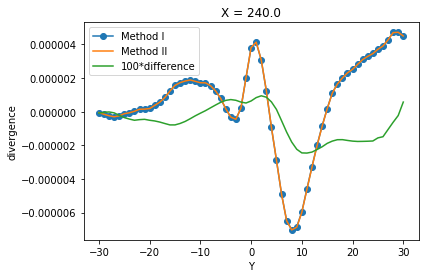

In [9]:
div1 = ds.sel(X=240,Y=slice(30,-30)).divergence1
div2 = ds.sel(X=240,Y=slice(30,-30)).divergence
div_diff = (div2 - div1)*100
div1.plot(marker='o', label="Method I")
div2.plot(label="Method II")
div_diff.plot(label="100*difference")
plt.legend()

In [ ]:
del ds['divergence1']

### Gradient

The gradient of a scalar field, $F$, in spherical coordinates is

$$ \nabla F =  (\frac{1}{cos y}\frac{\partial F}{\partial x} , \
                     \frac{\partial F}{\partial y} )$$



In [ ]:
# calculate the gradient of the mean 10m wind speed, si10
ds.si10.plot()

In [ ]:
Fhx = grid.interp(ds.si10,axis='X')
Fhy = grid.interp(ds.si10,axis='Y')
ds['wnspgradx'] = grid.diff(Fhx,axis='X')/(dxm*coslat)
ds['wnspgrady'] = grid.diff(Fhy,axis='Y')/dym

In [ ]:
#plt.quiver(ds.X, ds.Y[5:-5], gradx[0,5:-5], grady[0,5:-5])
ds.sel(X=240,Y=slice(30,-30)).wnspgradx.plot()
ds.sel(X=240,Y=slice(30,-30)).wnspgrady.plot()
plt.legend()

### Curl

The curl of $\vec u = (u,v)$ in spherical coordinates is

$$ \nabla \times \vec u =  \frac{1}{\cos y} \left ( \frac{\partial v}{\partial x}  - \frac{\partial (u \cos y)}{\partial y} \right
                                     )$$



In [ ]:
uh = grid.interp(ds.u10,axis='Y')
vh = grid.interp(ds.v10,axis='X')
dudy = grid.diff(uh*coslath,axis='Y')/dym
dvdx = grid.diff(vh,axis='X')/dxm
ds['curl'] = (dvdx - dudy)/coslat
ds

In [ ]:
ds.curl[5:-5].plot(vmin = -1e-5, vmax = 1e-5)